Automatic estimation of Ejection Fraction from echocardiographic images using the Simpson's biplane method of disks
===

***
# <span style="color:brown"> Preamble

This notebook provides a method to compute the ejection fraction from Simpson's biplane method of disks using the segmentation obtained from 2D echocardiographic images at end diastole and end systole time instances from Apical two and four chambers views. This method was used in the following paper:

Leclerc S, Smistad E, Pedrosa J, Østvik A, Cervenansky F, Espinosa F, Espeland T, Rye Berg EA, Jodoin PM, Grenier T, Lartizien C, D’hooge J, Lovstakken L, Bernard O. "Deep Learning for Segmentation using an Open Large-Scale Dataset in 2D Echocardiography" IEEE Trans Med Imaging, 2019:38:2198-2210, DOI: 10.1109/TMI.2019.2900516
    
# <span style="color:brown"> Objectives

* Provide the code to compute EF for open science purposes 
* This code can be run from the [CAMUS dataset](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/6373703d73e9f0047faa1bc8) to reproduce the EF values provided in this collection
    
***

# <span style="color:brown"> Warnings

* We have observed that the way in which Simpson's biplane method is implemented can have a significant influence on the final values calculated. We do not guarantee that the method implemented in this notebook is optimal. The values produced by this method should be used with caution.
    

## Import the different python librairies

In [1]:
import logging
from pathlib import Path
from typing import Any, Dict, Tuple

import numpy as np
import PIL
import SimpleITK as sitk
from PIL.Image import Resampling
from skimage.measure import find_contours

logger = logging.getLogger(__name__)

## Let's define a few useful functions to load and manipulate images

In [2]:
def sitk_load(filepath: str | Path) -> Tuple[np.ndarray, Dict[str, Any]]:
    """Loads an image using SimpleITK and returns the image and its metadata.

    Args:
        filepath: Path to the image.

    Returns:
        - ([N], H, W), Image array.
        - Collection of metadata.
    """
    # Load image and save info
    image = sitk.ReadImage(str(filepath))
    info = {
        "origin": image.GetOrigin(),
        "spacing": image.GetSpacing(),
        "direction": image.GetDirection(),
    }

    # Extract numpy array from the SimpleITK image object
    im_array = np.squeeze(sitk.GetArrayFromImage(image))

    return im_array, info

In [3]:
def resize_image(image: np.ndarray, size: Tuple[int, int], resample: Resampling = Resampling.NEAREST) -> np.ndarray:
    """Resizes the image to the specified dimensions.

    Args:
        image: (H, W), Input image to resize. Must be in a format supported by PIL.
        size: Width (W') and height (H') dimensions of the resized image to output.
        resample: Resampling filter to use.

    Returns:
        (H', W'), Input image resized to the specified dimensions.
    """
    resized_image = np.array(PIL.Image.fromarray(image).resize(size, resample=resample))
    return resized_image

In [4]:
def resize_image_to_isotropic(
    image: np.ndarray,
    spacing: Tuple[float, float],
    resample: Resampling = Resampling.NEAREST,
) -> np.ndarray:
    """Resizes the image to attain isotropic spacing, by resampling the dimension with the biggest voxel size.

    Args:
        image: (H, W), Input image to resize. Must be in a format supported by PIL.
        spacing: Size of the image's pixels along each (height, width) dimension.
        resample: Resampling filter to use.

    Returns:
        (H', W'), Input image resized so that the spacing is isotropic, and the isotropic value of the new spacing.
    """
    scaling = np.array(spacing) / min(spacing)
    new_height, new_width = (np.array(image.shape) * scaling).round().astype(int)
    return resize_image(image, (new_width, new_height), resample=resample), min(spacing)

## Implement Simpson's biplane method of disks

In [5]:
def compute_left_ventricle_volumes(
    a2c_ed: np.ndarray,
    a2c_es: np.ndarray,
    a2c_voxelspacing: Tuple[float, float],
    a4c_ed: np.ndarray,
    a4c_es: np.ndarray,
    a4c_voxelspacing: Tuple[float, float],
) -> Tuple[float, float]:
    """Computes the ED and ES volumes of the left ventricle from 2 orthogonal 2D views (A2C and A4C).

    Args:
        a2c_ed: (H,W), Binary segmentation map of the left ventricle from the end-diastole (ED) instant of the 2-chamber
            apical view (A2C).
        a2c_es: (H,W), Binary segmentation map of the left ventricle from the end-systole (ES) instant of the 2-chamber
            apical view (A2C).
        a2c_voxelspacing: Size (in mm) of the 2-chamber apical view's voxels along each (height, width) dimension.
        a4c_ed: (H,W), Binary segmentation map of the left ventricle from the end-diastole (ED) instant of the 4-chamber
            apical view (A4C).
        a4c_es: (H,W), Binary segmentation map of the left ventricle from the end-systole (ES) instant of the 4-chamber
            apical view (A4C).
        a4c_voxelspacing: Size (in mm) of the 4-chamber apical view's voxels along each (height, width) dimension.

    Returns:
        Left ventricle ED and ES volumes.
    """
    for mask_name, mask in [
        ("a2c_ed", a2c_ed),
        ("a2c_es", a2c_es),
        ("a4c_ed", a4c_ed),
        ("a4c_es", a4c_es),
    ]:
        if mask.max() > 1:
            logger.warning(
                f"`compute_left_ventricle_volumes` expects binary segmentation masks of the left ventricle (LV). "
                f"However, the `{mask_name}` segmentation contains a label greater than '1/True'. If this was done "
                f"voluntarily, you can safely ignore this warning. However, the most likely cause is that you forgot "
                f"to extract the binary LV segmentation from a multi-class segmentation mask."
            )

    a2c_ed_diameters, a2c_ed_step_size = _compute_diameters(a2c_ed, a2c_voxelspacing)
    a2c_es_diameters, a2c_es_step_size = _compute_diameters(a2c_es, a2c_voxelspacing)
    a4c_ed_diameters, a4c_ed_step_size = _compute_diameters(a4c_ed, a4c_voxelspacing)
    a4c_es_diameters, a4c_es_step_size = _compute_diameters(a4c_es, a4c_voxelspacing)
    step_size = max((a2c_ed_step_size, a2c_es_step_size, a4c_ed_step_size, a4c_es_step_size))

    ed_volume = _compute_left_ventricle_volume_by_instant(a2c_ed_diameters, a4c_ed_diameters, step_size)
    es_volume = _compute_left_ventricle_volume_by_instant(a2c_es_diameters, a4c_es_diameters, step_size)
    return ed_volume, es_volume


def _compute_left_ventricle_volume_by_instant(
    a2c_diameters: np.ndarray, a4c_diameters: np.ndarray, step_size: float
) -> float:
    """Compute left ventricle volume using Biplane Simpson's method.

    Args:
        a2c_diameters: Diameters measured at each key instant of the cardiac cycle, from the 2-chamber apical view.
        a4c_diameters: Diameters measured at each key instant of the cardiac cycle, from the 4-chamber apical view.
        step_size:

    Returns:
        Left ventricle volume (in millilitres).
    """
    # All measures are now in millimeters, convert to meters by dividing by 1000
    a2c_diameters /= 1000
    a4c_diameters /= 1000
    step_size /= 1000

    # Estimate left ventricle volume from orthogonal disks
    lv_volume = np.sum(a2c_diameters * a4c_diameters) * step_size * np.pi / 4

    # Volume is now in cubic meters, so convert to milliliters (1 cubic meter = 1_000_000 milliliters)
    return round(lv_volume * 1e6)


def _find_distance_to_edge(
    segmentation: np.ndarray,
    point_on_mid_line: np.ndarray,
    normal_direction: np.ndarray,
) -> float:
    distance = 8  # start a bit in to avoid line stopping early at base
    while True:
        current_position = point_on_mid_line + distance * normal_direction

        y, x = np.round(current_position).astype(int)
        if segmentation.shape[0] <= y or y < 0 or segmentation.shape[1] <= x or x < 0:
            # out of bounds
            return distance

        elif segmentation[y, x] == 0:
            # Edge found
            return distance

        distance += 0.5


def _distance_line_to_points(line_point_0: np.ndarray, line_point_1: np.ndarray, points: np.ndarray) -> np.ndarray:
    # https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    return np.absolute(np.cross(line_point_1 - line_point_0, line_point_0 - points)) / np.linalg.norm(
        line_point_1 - line_point_0
    )


def _get_angle_of_lines_to_point(reference_point: np.ndarray, moving_points: np.ndarray) -> np.ndarray:
    diff = moving_points - reference_point
    return abs(np.degrees(np.arctan2(diff[:, 0], diff[:, 1])))


def _compute_diameters(segmentation: np.ndarray, voxelspacing: Tuple[float, float]) -> Tuple[np.ndarray, float]:
    """

    Args:
        segmentation: Binary segmentation of the structure for which to find the diameter.
        voxelspacing: Size of the segmentations' voxels along each (height, width) dimension (in mm).

    Returns:
    """

    # Make image isotropic, have same spacing in both directions.
    # The spacing can be multiplied by the diameter directly.
    segmentation, isotropic_spacing = resize_image_to_isotropic(segmentation, voxelspacing)

    # Go through entire contour to find AV plane
    contour = find_contours(segmentation, 0.5)[0]

    # For each pair of contour points
    # Check if angle is ok
    # If angle is ok, check that almost all other contour points are above the line
    # Or check that all points between are close to the line
    # If so, it is accepted, select the longest stretch
    best_length = 0
    for point_idx in range(2, len(contour)):
        previous_points = contour[:point_idx]
        angles_to_previous_points = _get_angle_of_lines_to_point(contour[point_idx], previous_points)

        for acute_angle_idx in np.nonzero(angles_to_previous_points <= 45)[0]:
            intermediate_points = contour[acute_angle_idx + 1 : point_idx]
            distance_to_intermediate_points = _distance_line_to_points(
                contour[point_idx], contour[acute_angle_idx], intermediate_points
            )
            if np.all(distance_to_intermediate_points <= 8):
                distance = np.linalg.norm(contour[point_idx] - contour[acute_angle_idx])
                if best_length < distance:
                    best_length = distance
                    best_i = point_idx
                    best_j = acute_angle_idx

    mid_point = int(best_j + round((best_i - best_j) / 2))
    # Apex is longest from midpoint
    mid_line_length = 0
    apex = 0
    for i in range(len(contour)):
        length = np.linalg.norm(contour[mid_point] - contour[i])
        if mid_line_length < length:
            mid_line_length = length
            apex = i

    direction = contour[apex] - contour[mid_point]
    normal_direction = np.array([-direction[1], direction[0]])
    normal_direction = normal_direction / np.linalg.norm(normal_direction)  # Normalize
    diameters = []
    for fraction in np.linspace(0, 1, 20, endpoint=False):
        point_on_mid_line = contour[mid_point] + direction * fraction

        distance1 = _find_distance_to_edge(segmentation, point_on_mid_line, normal_direction)
        distance2 = _find_distance_to_edge(segmentation, point_on_mid_line, -normal_direction)
        diameters.append((distance1 + distance2) * isotropic_spacing)

    step_size = (mid_line_length * isotropic_spacing) / 20
    return np.array(diameters), step_size


## Load the 2D segmentation masks required to compute the left ventricular volumes and ejection fraction (EF) for one patient

NOTE: The following cells assume that the `database_nifti` archive was downloaded and extracted in the current directory.

In [19]:
###########################################
# PARAMETERS TO PLAY WITH

database_nifti_root = Path("../data/CAMUS/database_nifti")
pred_dir = database_nifti_root / "segresnet-eval"
lv_label = 1
# Select the patient identification (scalar value between 1 and 500)
patient_id = 120

In [20]:
print(database_nifti_root)

../data/CAMUS/database_nifti


In [61]:
# Specify the ID and path of the patient to be loaded
patient_name = f"patient{patient_id:04d}"
patient_dir = database_nifti_root / patient_name
img_pattern = "{patient_name}_{view}_{instant}.nii.gz"
gt_mask_pattern = "{patient_name}_{view}_{instant}_gt.nii.gz"
pred_mask_pattern = "{patient_name}_{view}_{instant}_pred.nii.gz"
print(f"Loading data from patient folder: {patient_dir}")

Loading data from patient folder: ../data/CAMUS/database_nifti/patient0120


In [62]:
view = "2CH"
instant = "ED"
a2c_ed_img, _ = sitk_load(patient_dir / img_pattern.format(patient_name=patient_name, view=view, instant=instant))
a2c_ed, a2c_info = sitk_load(pred_dir / pred_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a2c_ed_gt, _ = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a2c_voxelspacing = a2c_info["spacing"][:2][
    ::-1
]  # Extract the (width,height) dimension from the metadata and order them like in the mask

In [63]:
instant = "ES"
a2c_es_img, _ = sitk_load(patient_dir / img_pattern.format(patient_name=patient_name, view=view, instant=instant))
a2c_es, _ = sitk_load(pred_dir / pred_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a2c_es_gt, _ = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))

In [64]:
view = "4CH"
instant = "ED"
a4c_ed_img, _ = sitk_load(patient_dir / img_pattern.format(patient_name=patient_name, view=view, instant=instant))
a4c_ed, a4c_info = sitk_load(pred_dir / pred_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a4c_ed_gt, _ = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a4c_voxelspacing = a4c_info["spacing"][:2][
    ::-1
]  # Extract the (width,height) dimension from the metadata and order them like in the mask

In [65]:
instant = "ES"
a4c_es_img, _ = sitk_load(patient_dir / img_pattern.format(patient_name=patient_name, view=view, instant=instant))
a4c_es, _ = sitk_load(pred_dir / pred_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a4c_es_gt, _ = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))

In [66]:
import matplotlib.pyplot as plt

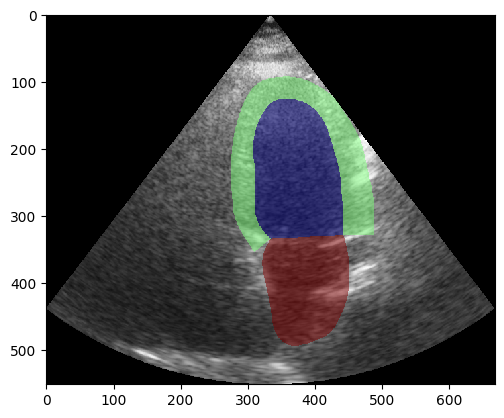

In [76]:
masked_gt = np.ma.masked_where(a4c_es_gt == 0, a4c_es_gt)
masked_pred = np.ma.masked_where(a4c_es == 0, a4c_es)
plt.imshow(a4c_es_img, cmap="gray", interpolation="none")
plt.imshow(masked_gt, alpha=0.5, interpolation="none", cmap="jet")
plt.show()

## Run Simpson's biplane method of disks on the data from the selected patient

In [70]:
# Extract binary LV masks from the multi-class segmentation masks
a2c_ed_lv_mask = a2c_ed == lv_label
a2c_es_lv_mask = a2c_es == lv_label
a4c_ed_lv_mask = a4c_ed == lv_label
a4c_es_lv_mask = a4c_es == lv_label

# Use the provided implementation to compute the LV volumes
edv, esv = compute_left_ventricle_volumes(
    a2c_ed_lv_mask,
    a2c_es_lv_mask,
    a2c_voxelspacing,
    a4c_ed_lv_mask,
    a4c_es_lv_mask,
    a4c_voxelspacing,
)
ef = round(100 * (edv - esv) / edv)  # Round the computed value to the nearest integer

print(f"{patient_name=}: {ef=}, {edv=}, {esv=}")

/tmp/ipykernel_1186359/2390536577.py:99: RuntimeWarning: invalid value encountered in divide
  return np.absolute(np.cross(line_point_1 - line_point_0, line_point_0 - points)) / np.linalg.norm(


patient_name='patient0120': ef=34, edv=2206, esv=1458
